<a href="https://colab.research.google.com/github/NikitaKozhemyakin/python_amms/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22dl_nlp_toxic_comment_classification_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Классификация [токсичных комментариев](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

Пример решения задачи многозначной классификации. Архитектура сети основывается на [описании решения](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644) 3 места в конкурсе.

Учебный курс "[Нейросети для анализа текстов](https://www.asozykin.ru/courses/nnpython)".

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU, чтобы сеть обучалась быстрее (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU).

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
%matplotlib inline 

In [ ]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина комментария
max_comment_len = 50

## Загрузка набора данных

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/XVbmK6lZZpBGGw'  # Сюда вписываете вашу ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('dataset.txt', 'wb') as f:   # Здесь укажите нужный путь к файлу
    f.write(download_response.content)

data_list = []
with open("dataset.txt") as file:
    for line in file:
        labels = line.split()[0]
        text = line[len(labels)+1:].strip()
        labels = labels.split(",")
        mask = [1 if "__label__NORMAL" in labels else 0,
                1 if "__label__INSULT" in labels else 0,
                1 if "__label__THREAT" in labels else 0,
                1 if "__label__OBSCENITY" in labels else 0]
        data_list.append((text, *mask))
df = pd.DataFrame(data_list, columns=["text", "normal", "insult", "threat", "obscenity"])
df



#тестовые
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/ZCJV_1pQCTEK7g'  # Сюда вписываете вашу ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('labeledtest.txt', 'wb') as f:   # Здесь укажите нужный путь к файлу
    f.write(download_response.content)

data_list = []
with open("labeledtest.txt") as file:
    for line in file:
        labels = line.split()[0]
        text = line.strip()
        labels = labels.split(",")
        mask = [1 if "0.0" in labels else 0,
                1 if "1.0" in labels else 0,
                1 if "1.0" in labels else 0,
                1 if "1.0" in labels else 0]
        data_list.append((text, *mask))
testf = pd.DataFrame(data_list, columns=["text", "normal", "insult", "threat", "obscenity"])
testf


,text,normal,insult,threat,obscenity
0,"0.0,""Балбес ты, вася! Ничего не понимаешь""",1,0,0,0
1,"1.0,""Верблюдов-то за что? Дебилы, бл...""",0,1,1,1
2,"1.0,""Хохлы, это отдушина затюканого россиянина...",0,1,1,1
3,"1.0,""Собаке - собачья смерть""",0,1,1,1
4,"1.0,""Страницу обнови, дебил. Это тоже не оскор...",0,1,1,1
...,...,...,...,...,...
14408,"1.0,""Вонючий совковый скот прибежал и ноет. А ...",0,1,1,1
14409,"1.0,""А кого любить? Гоблина тупорылого что-ли?...",0,1,1,1
14410,"0.0,""Посмотрел Утомленных солнцем 2. И оказало...",1,0,0,0
14411,"1.0,""КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В ...",0,1,1,1


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!unzip test.csv.zip
!unzip test_labels.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         


## Просматриваем данные

In [ ]:
!ls

sample_data		   test.csv	 test_labels.csv      train.csv
sample_submission.csv.zip  test.csv.zip  test_labels.csv.zip  train.csv.zip


In [ ]:
!head -20 dataset.txt

__label__INSULT скотина! что сказать
__label__NORMAL я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином ( на пустыре) бежала кошка похожего окраса. может, я и ошиблась, но необычный окрас бросился в глаза.
__label__NORMAL очередной лохотрон. зачем придумывать очередной налог на воздух, если можно обьявить инсульт и грипп- пандемией! и лихо на придурках зарабатывать годами на штрафах, фейковых вакцинах, всевозможных платных тестах, продажей масок и перчаток по баснословным ценам.. самое смешное, что бараны блеют и верят пастуху, телевизору. живут как под гипнозом. не думая, не глядя по сторонам.
__label__NORMAL ретро дежавю ... сложно понять чужое сердце , лиш ощутить музыкой видимо
__label__NORMAL а когда мы статус агрогородка получили?
__label__NORMAL 2 августа поздно вечером нашли вот такую потеряшку в районе высоток на победе. девочка явно домашняя, в новом ошейнике. обращаться +7 989 816-43-42
__label__NORMAL вчера надыбала новые стикеры #u2a94ec7fabs#

In [ ]:
!head -20 labeledtest.txt

1.0,"Глупый гой пытается попасть в элиту этог

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Загружаем данные в память

Читаем данные из файла

In [ ]:
train = df

In [ ]:
train

,text,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0
...,...,...,...,...,...
248285,правильно всё по пять (5)...,1,0,0,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,0,1,0,0
248287,а у меня наверное рекорд в 1962 году в училище...,1,0,0,0
248288,спасибо всем большое),1,0,0,0


Выделяем данные для обучения

In [ ]:
comments = train['text']

In [ ]:
comments[:5]

0                                 скотина! что сказать
1    я сегодня проезжала по рабочей и между домами ...
2    очередной лохотрон. зачем придумывать очередно...
3    ретро дежавю ... сложно понять чужое сердце , ...
4              а когда мы статус агрогородка получили?
Name: text, dtype: object

Выделяем правильные ответы

In [ ]:
y_train = train[['normal', 'insult', 'threat', 'obscenity']]

In [ ]:
y_train

,normal,insult,threat,obscenity
0,0,1,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
248285,1,0,0,0
248286,0,1,0,0
248287,1,0,0,0
248288,1,0,0,0


## Токенизация текста

In [ ]:
comments[:5]

0                                 скотина! что сказать
1    я сегодня проезжала по рабочей и между домами ...
2    очередной лохотрон. зачем придумывать очередно...
3    ретро дежавю ... сложно понять чужое сердце , ...
4              а когда мы статус агрогородка получили?
Name: text, dtype: object

Создаем токенизатор Keras

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на новостях

In [ ]:
tokenizer.fit_on_texts(comments)

Просматриваем словарь токенизатора

In [ ]:
tokenizer.word_index

{'и': 1,
 'не': 2,
 'в': 3,
 'а': 4,
 'на': 5,
 'что': 6,
 'с': 7,
 'это': 8,
 'я': 9,
 'как': 10,
 'у': 11,
 'за': 12,
 'то': 13,
 'по': 14,
 'все': 15,
 'так': 16,
 'ты': 17,
 'вы': 18,
 'бы': 19,
 'но': 20,
 'да': 21,
 'надо': 22,
 'о': 23,
 'только': 24,
 'если': 25,
 'он': 26,
 'кто': 27,
 'вот': 28,
 'от': 29,
 'к': 30,
 'есть': 31,
 'же': 32,
 'очень': 33,
 'нет': 34,
 'для': 35,
 'уже': 36,
 'они': 37,
 'его': 38,
 'мне': 39,
 'из': 40,
 'будет': 41,
 'или': 42,
 'вам': 43,
 'можно': 44,
 'мы': 45,
 'было': 46,
 'где': 47,
 'их': 48,
 'меня': 49,
 'нас': 50,
 'когда': 51,
 'до': 52,
 'просто': 53,
 'ну': 54,
 'тоже': 55,
 'там': 56,
 'спасибо': 57,
 'вас': 58,
 'ещё': 59,
 'всё': 60,
 'тебя': 61,
 'она': 62,
 'всех': 63,
 'тебе': 64,
 'может': 65,
 'ни': 66,
 'без': 67,
 'здоровья': 68,
 'всем': 69,
 'люди': 70,
 'сейчас': 71,
 'сколько': 72,
 'лет': 73,
 'б': 74,
 'даже': 75,
 'чтобы': 76,
 'нужно': 77,
 'еще': 78,
 'чем': 79,
 'пусть': 80,
 'd': 81,
 'такой': 82,
 'какой': 83

Преобразуем комментарии в числовое представление

In [ ]:
sequences = tokenizer.texts_to_sequences(comments)

Просматриваем новости в числовом представлении

In [ ]:
index = 1
print(comments[index])
print(sequences[index])

я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином ( на пустыре) бежала кошка похожего окраса. может, я и ошиблась, но необычный окрас бросился в глаза.
[9, 177, 14, 8242, 1, 678, 1, 5, 1517, 65, 9, 1, 6033, 20, 7307, 3, 409]


In [ ]:
tokenizer.word_index['дурак']

1474

Ограничиваем длину отзывов

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_comment_len)

In [ ]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 2921,    6,  323],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           9,  177,   14, 8242,    1,  678,    1,    5, 1517,   65,    9,
           1, 6033,   20, 7307,    3,  409],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 1172, 2759,  149, 1172, 4433,
           5, 2138,   25,   44,    1,    1,    5, 3424, 2844,    5, 2192,
           1,   14, 6993,  280,    6, 3468,    1, 2246, 4934,  372,   10,
         122,    2, 76

## Cеть LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 128, input_length=max_comment_len))
model_lstm.add(SpatialDropout1D(0.5))
model_lstm.add(LSTM(40, return_sequences=True))
model_lstm.add(LSTM(40))
model_lstm.add(Dense(4, activation='sigmoid'))

In [ ]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50, 40)            27040     
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 4)                 164       
                                                                 
Total params: 1,320,164
Trainable params: 1,320,164
Non-trainable params: 0
______________________________________________

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [ ]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=512,
                              validation_split=0.2,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
387/388 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.8731 - auc: 0.9594
Epoch 1: val_accuracy improved from -inf to 0.92706, saving model to best_model_lstm.h5
388/388 [==============================] - 16s 16ms/step - loss: 0.2142 - accuracy: 0.8733 - auc: 0.9594 - val_loss: 0.1324 - val_accuracy: 0.9271 - val_auc: 0.9839
Epoch 2/5
388/388 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9313 - auc: 0.9859
Epoch 2: val_accuracy improved from 0.92706 to 0.93057, saving model to best_model_lstm.h5
388/388 [==============================] - 5s 13ms/step - loss: 0.1231 - accuracy: 0.9313 - auc: 0.9859 - val_loss: 0.1219 - val_accuracy: 0.9306 - val_auc: 0.9862
Epoch 3/5
388/388 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9357 - auc: 0.9882
Epoch 3: val_accuracy improved from 0.93057 to 0.93598, saving model to best_model_lstm.h5
388/388 [==============================] - 5s 13ms/step - loss: 0.1120 - a

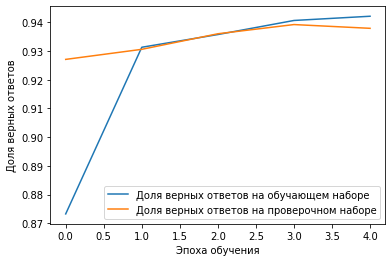

In [ ]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [ ]:
test_comments = testf['text']

In [ ]:
test_comments[:10]

0           0.0,"Балбес ты, вася! Ничего не понимаешь"
1             1.0,"Верблюдов-то за что? Дебилы, бл..."
2    1.0,"Хохлы, это отдушина затюканого россиянина...
3                        1.0,"Собаке - собачья смерть"
4    1.0,"Страницу обнови, дебил. Это тоже не оскор...
5    1.0,"тебя не убедил 6-страничный пдф в том, чт...
6    1.0,"Для каких стан является эталоном современ...
7    0.0,"В шапке были ссылки на инфу по текущему ф...
8    1.0,"УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕ...
9                    1.0,"Ебать тебя разносит, шизик."
Name: text, dtype: object

In [ ]:
test_labels = testf[['normal', 'insult', 'threat', 'obscenity']]

In [ ]:
test_labels[:10]

,normal,insult,threat,obscenity
0,1,0,0,0
1,0,1,1,1
2,0,1,1,1
3,0,1,1,1
4,0,1,1,1
5,0,1,1,1
6,0,1,1,1
7,1,0,0,0
8,0,1,1,1
9,0,1,1,1


In [ ]:
test_full = testf

In [ ]:
test_full

,text,normal,insult,threat,obscenity
0,"0.0,""Балбес ты, вася! Ничего не понимаешь""",1,0,0,0
1,"1.0,""Верблюдов-то за что? Дебилы, бл...""",0,1,1,1
2,"1.0,""Хохлы, это отдушина затюканого россиянина...",0,1,1,1
3,"1.0,""Собаке - собачья смерть""",0,1,1,1
4,"1.0,""Страницу обнови, дебил. Это тоже не оскор...",0,1,1,1
...,...,...,...,...,...
14408,"1.0,""Вонючий совковый скот прибежал и ноет. А ...",0,1,1,1
14409,"1.0,""А кого любить? Гоблина тупорылого что-ли?...",0,1,1,1
14410,"0.0,""Посмотрел Утомленных солнцем 2. И оказало...",1,0,0,0
14411,"1.0,""КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В ...",0,1,1,1


In [ ]:
test = test_full

In [ ]:
test

,text,normal,insult,threat,obscenity
0,"0.0,""Балбес ты, вася! Ничего не понимаешь""",1,0,0,0
1,"1.0,""Верблюдов-то за что? Дебилы, бл...""",0,1,1,1
2,"1.0,""Хохлы, это отдушина затюканого россиянина...",0,1,1,1
3,"1.0,""Собаке - собачья смерть""",0,1,1,1
4,"1.0,""Страницу обнови, дебил. Это тоже не оскор...",0,1,1,1
...,...,...,...,...,...
14408,"1.0,""Вонючий совковый скот прибежал и ноет. А ...",0,1,1,1
14409,"1.0,""А кого любить? Гоблина тупорылого что-ли?...",0,1,1,1
14410,"0.0,""Посмотрел Утомленных солнцем 2. И оказало...",1,0,0,0
14411,"1.0,""КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В ...",0,1,1,1


Преобразуем комментарии в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['text'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_comment_len)

In [ ]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  278,
         278,   17, 5760,  110,    2, 2271],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  120,
         278,   13,   12,    6,  737, 4623],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  120,  278,
        1746,    8, 4112, 1631,    4,   11, 3089,   78,  567,   25,   19,
        3089,    2,   

Правильные ответы

In [ ]:
y_test = test[['normal', 'insult', 'threat', 'obscenity']]

In [ ]:
y_test[:10]

,normal,insult,threat,obscenity
0,1,0,0,0
1,0,1,1,1
2,0,1,1,1
3,0,1,1,1
4,0,1,1,1
5,0,1,1,1
6,0,1,1,1
7,1,0,0,0
8,0,1,1,1
9,0,1,1,1


## Оцениваем качество работы сети на тестовом наборе данных

In [ ]:
model_lstm.load_weights(model_lstm_save_path)

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

451/451 [==============================] - 2s 5ms/step - loss: 1.2784 - accuracy: 0.7621 - auc: 0.7814


[1.27835214138031, 0.7620897889137268, 0.7814098000526428]

## Пробуем классифицировать комментарии

In [ ]:
comment = "видел сегодня, как какой-то ... задавил собачку. изверги"

In [ ]:
sequence = tokenizer.texts_to_sequences([comment])

In [ ]:
sequence

[[733, 177, 10, 83, 13, 3359]]

In [ ]:
data = pad_sequences(sequence, maxlen=max_comment_len)

In [ ]:
data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         733,  177,   10,   83,   13, 3359]], dtype=int32)

In [ ]:
result = model_lstm.predict(data)

In [ ]:
result

array([[9.8885602e-01, 9.5525803e-03, 3.8835662e-04, 2.2313304e-03]],
      dtype=float32)